Multi Class Image Classification

In [1]:
#join google-drive to the code
from google.colab import drive #to connect google drive to the code
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#!/usr/bin/python3
#encoding=utf8

import tensorflow as tf
from tensorflow import keras

import numpy as np # linear algebra
import xml.etree.ElementTree as ET # for parsing XML
import matplotlib.pyplot as plt # to show images 

from PIL import Image
import os
import sys
import pickle,time

print(tf.__version__)

#test, if size too large, then shrink it.
IMAGE_SIZE=(192,192)
IMAGE_SHAPE=(192,192,3)
BATCH_SIZE=3000 #9000

1.13.1


In [ ]:
#============================Utils======================================
def showImg(img):
    plt.figure()
    plt.imshow(train_images[0])
    plt.colorbar()
    plt.grid(False)
    plt.show()

def saveObj(obj,filename):#dump Object to local
    output = open(filename, 'wb+')
    pickle.dump(obj,output)
    output.close()

def loadObjsIfExist(filename):#Load objects at startup
    result= None
    if os.path.exists(filename):
        pkl_file = open(filename, 'rb')
        result = pickle.load(pkl_file)
        pkl_file.close()
    return result 

In [ ]:
#============================data preparation.==========================

LABELS = {"airplane":0,  "car":1,  "cat":2,  "dog":3,  "flower":4,  "fruit":5,  "motorbike":6,  "person":7}
LABELS_R = {}
for itm in LABELS.keys():
    LABELS_R[LABELS[itm]] = itm

def readSamples():
    objs=[]
    for c in os.listdir('/content/drive/My Drive/Assignment6/Data/natural_images_input/'):
        for m in os.listdir('/content/drive/My Drive/Assignment6/Data/natural_images_input/'+c):
            picpath="/content/drive/My Drive/Assignment6/Data/natural_images_input/"+c+"/"+m
            nodeInfo={"imgdir":picpath, "label":LABELS[c]}
            objs.append(nodeInfo)
    np.random.shuffle(objs)
    testRange = int(len(objs)*0.20)
    actualTrainObjs = objs[testRange:]
    actualTestObjs = objs[:testRange]
    return actualTrainObjs, actualTestObjs 

In [ ]:
def readTrainSamples(actualTrainObjs):
    divider=20
    objTrain=[]
    objTest=[]
    for item in actualTrainObjs:
        _magic = np.random.choice(range(divider))
        if _magic==0: objTest.append(item)
        else: objTrain.append(item)
    np.random.shuffle(objTrain)
    np.random.shuffle(objTest)
    return objTrain, objTest

In [ ]:
def loadRawData(actualTrainObjs):
    # if the data not been loaded. then load, and save as python objects.
    anfileTrain ="/content/drive/My Drive/Assignment6/Data/natural_images_output/annoObj.train.obj"
    anfileTest ="/content/drive/My Drive/Assignment6/Data/natural_images_output/annoObj.test.obj"
    annoObjTrain = loadObjsIfExist(anfileTrain)
    annoObjTest = loadObjsIfExist(anfileTest)
    if not annoObjTrain:
        print("raw data not exist, loading....")
        annoObjTrain, annoObjTest = readTrainSamples(actualTrainObjs)
        print("raw data loaded, saving as files: ",anfileTrain, anfileTest)
        saveObj(annoObjTrain,anfileTrain)
        saveObj(annoObjTest,anfileTest)
    print("raw data loaded. There are %d training samples and %d testing samples"%(len(annoObjTrain), len(annoObjTest)))
    return annoObjTrain, annoObjTest


In [ ]:
def preProcessBatch(tag, annoObj):
    #if the data has not been pre-processed, the process the data.
    #1. generate the label sets.
    #2. save configure info.
    confFile ="/content/drive/My Drive/Assignment6/Data/natural_images_output/"+tag+"config.obj"
    confs= loadObjsIfExist(confFile)
    if not confs:
        confs = {}
    #3. generate batchs, 200 items each. 
    # too many images, so we should not load them all at once, we need to load needed images as we training.
    batchs=[]
    bacthcnt=0
    objbatch=[]
    objcnt=0
    for pic in annoObj:
        objcnt+=1
        objbatch.append(pic)
        if (objcnt%BATCH_SIZE==0 or objcnt == len(annoObj)):
            batchfile="/content/drive/My Drive/Assignment6/Data/natural_images_output/objbatch_"+tag+str(bacthcnt)
            batchs.append(batchfile)
            saveObj(objbatch, batchfile)
            print(objcnt, bacthcnt, len(objbatch))
            objbatch=[]
            bacthcnt+=1
    #3. save confs
    confs["objcnt"] = objcnt
    confs["batchs"] = batchs
    confs["bacthcnt"] = bacthcnt
    print(confs)
    saveObj(confs, confFile)
    pass
    

In [ ]:
#============================Images process=============================
def readPic(pic):
    picdir = pic["imgdir"]
    #1. find picture
    if not picdir:
        return None
    if not os.path.exists(picdir):
        return None
    img = Image.open(picdir)
    imgobj= img.resize(IMAGE_SIZE)
    #4. normalnize the data between 0,1
    imgobj = np.array(imgobj)/ 255.0
    if (imgobj.ndim < 3) or (imgobj.shape != IMAGE_SHAPE):
        #exception: this picture is not a RGB picture. 
        return None
    #5. split data set into different batch
    return imgobj

In [ ]:
def loadImagesBatch(batchfile):
    #1.load images as numpy's ndarray
    objbatch =loadObjsIfExist(batchfile)
    imgarray = []
    labels = []
    for pic in objbatch:
        imgobj = readPic(pic)
        if imgobj is None: 
            continue # in case picture is wrong.
        imgarray.append(imgobj)
        labels.append(int(pic["label"]))##category for softmax should start with 0.
    imgarray = np.array(imgarray)
    labels=np.array(labels)
    return imgarray,labels

In [ ]:
def loadConf(tag):
    confFile ="/content/drive/My Drive/Assignment6/Data/natural_images_output/"+tag+"config.obj"
    confs= loadObjsIfExist(confFile)
    return confs

In [ ]:
#============================Tensorflow=================================
def buildModel():
    #1. build model.
    #2. compile the model
    tfmodel = tf.keras.models.Sequential([
    #keras.layers.Flatten(input_shape=IMAGE_SHAPE),
    keras.layers.Conv2D(32, kernel_size=(5, 5), activation=tf.keras.activations.relu, input_shape=IMAGE_SHAPE),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis = 1),
    keras.layers.Dropout(0.22), 
    keras.layers.Conv2D(32, kernel_size=(5, 5), activation=tf.keras.activations.relu),
    keras.layers.AveragePooling2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis = 1),
    keras.layers.Dropout(0.25),
    keras.layers.Conv2D(32, kernel_size=(4, 4), activation=tf.keras.activations.relu),
    keras.layers.AveragePooling2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis = 1),
    keras.layers.Dropout(0.15),
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation=tf.keras.activations.relu),
    keras.layers.AveragePooling2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis = 1),
    keras.layers.Dropout(0.15),
    keras.layers.Flatten(),    
    keras.layers.Dense(256, activation=tf.keras.activations.relu,kernel_regularizer=keras.regularizers.l2(0.001)),
    #keras.layers.Dropout(0.25),
    keras.layers.Dense(64, activation=tf.keras.activations.relu,kernel_regularizer=keras.regularizers.l2(0.001)),
    #keras.layers.Dropout(0.1),
    keras.layers.Dense(len(LABELS), activation=tf.keras.activations.softmax)
    ])
    tfmodel.compile(optimizer=tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.sparse_categorical_crossentropy,
                metrics=['accuracy'])
    return tfmodel


In [ ]:
def loadWeights(tfmodel):
    checkpoint_path="/content/drive/My Drive/Assignment6/Data/natural_images_output/chk/cp-{epoch:04d}.ckpt"
    if os.path.exists("/content/drive/My Drive/Assignment6/Data/natural_images_output/chk/checkpoint"):
        latest = tf.train.latest_checkpoint("/content/drive/My Drive/Assignment6/Data/natural_images_output/chk/")
        tfmodel.load_weights(latest)
        print("tfmodel loaded from: ",latest)
    return tfmodel

In [ ]:
def trainModel(tfmodel, train_images, train_labels, testX, testY, epochs=50):
    checkpoint_path="/content/drive/My Drive/Assignment6/Data/natural_images_output/chk/cp-{epoch:04d}.ckpt"
    cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 period=10)
    result = tfmodel.fit(train_images, train_labels,
          epochs = epochs, callbacks = [cp_callback],
          validation_data=(testX, testY),
          #validation_data = (test_images,test_labels),
          verbose=1)
    # return the fit history.
    return result, tfmodel

In [ ]:
def evaluteAccuracy(tfmodel, test_images, test_labels):
    loss, acc = tfmodel.evaluate(test_images, test_labels, verbose=1)
    return loss, acc

In [ ]:
def loadModel():
    tfmodel = buildModel()
    tfmodel = loadWeights(tfmodel)
    return tfmodel

In [ ]:
#============================Main logic============================
def training(tfmodel):
    #2. load config
    trainconf = loadConf("train")
    testconf = loadConf("test")
    trainBatchs = trainconf["batchs"]
    testBatchs = testconf["batchs"]
    #3. train model with each batch
    history =[]
    nBatch =0
    for batchfile in trainBatchs:
        imgarray,label = loadImagesBatch(batchfile)
        print("Load traing set:",imgarray.shape, label.shape, np.argmax(label), np.argmin(label))
        #4. evaluate the model with random test batch
        testbatch = np.random.choice(testBatchs)
        test_images,test_labels = loadImagesBatch(testbatch)
        print("Load test set:", test_images.shape, test_labels.shape)
        h1,tfmodel = trainModel(tfmodel,imgarray,label, test_images, test_labels, epochs=10)
        loss, acc = evaluteAccuracy(tfmodel, test_images,test_labels)
        #5. record the training history for further analysis.
        history.append((h1, loss, acc))
        nBatch+=1
        print(nBatch, "batch of training finished, loss and acc is:",loss, acc)

In [ ]:
def evaluateResult():
     #1. load model
    tfmodel = buildModel()
    tfmodel = loadWeights(tfmodel)
    tfmodel.summary()
    #2. load config
    testconf = loadConf("test")
    testBatchs = testconf["batchs"]
    history =[]
    nBatch =0
    #4. evaluate the model with random test batch
    testbatch = np.random.choice(testBatchs)
    test_images,test_labels = loadImagesBatch(testbatch)
    print(test_images.shape, test_labels.shape)
    loss, acc = evaluteAccuracy(tfmodel, test_images,test_labels)
    print("loss and acc is:",loss, acc)

In [ ]:
def predict(imgdir):
    tfmodel = buildModel()
    tfmodel = loadWeights(tfmodel)
    tfmodel.summary()
    test_images =[]
    figplot = plt.figure(figsize=(15, 15))
    imgs = os.listdir(imgdir)
    for imgpath in imgs:
        #1. Read data. 3. Make prediction.
        img = Image.open(imgdir+ imgpath)
        #2. resize into fixed size
        imgobj= img.resize(IMAGE_SIZE)
        #3. normalnize the data between 0,1
        imgobj = np.array(imgobj)/ 255.0
        test_images.append(imgobj)
    test_images = np.array(test_images)
    predictions = tfmodel.predict(test_images,verbose=1)
    print(LABELS_R)
    for i in range(len(predictions)):
        img = test_images[i]
        pre = predictions[i]*100
        print(pre)
        mostlikely = np.argmax(pre)
        txt = LABELS_R[mostlikely]
        chance = pre[mostlikely]
        plt.subplot(331 + i) # showing 9 random images
        plt.imshow(img) # displays photo
        plt.text(0, 0, txt+":"+str(chance)+"%", bbox={'ec': None}) # printing breed
    figplot.savefig("/content/drive/My Drive/Assignment6/Data/natural_images_output/001.png",format='png')
    pass

In [ ]:
def getTestLinksAndLabels(actualTestObjs):
    testImageLinks = []
    testImageLabels = []
    for item in actualTestObjs:
        link = list(item.values())[0]
        label = list(item.values())[1]
        testImageLinks.append(link)
        testImageLabels.append(label)
    return testImageLinks, testImageLabels 

In [ ]:
def predictActualTest(testImageLinks):
    tfmodel = buildModel()
    tfmodel = loadWeights(tfmodel)
    #tfmodel.summary()
    test_images =[]
    figplot = plt.figure(figsize=(15, 15))
    for imgpath in testImageLinks:
        #1. Read data. 3. Make prediction.
        img = Image.open(imgpath)
        #2. resize into fixed size
        imgobj= img.resize(IMAGE_SIZE)
        #3. normalnize the data between 0,1
        imgobj = np.array(imgobj)/ 255.0
        test_images.append(imgobj)
    test_images = np.array(test_images)
    predictions = tfmodel.predict(test_images,verbose=1)
    print(LABELS_R)
    
    #print(predictions,"\n\n")
    prediction_list = []
    prediction_label = []
    for i in range(len(predictions)):
        img = test_images[i]
        pre = predictions[i]*100
        mostlikely = np.argmax(pre)
        txt = LABELS_R[mostlikely]
        if(txt == 'airplane'): labelVal = 0
        elif(txt == 'car'): labelVal = 1
        elif(txt == 'cat'): labelVal = 2
        elif(txt == 'dog'): labelVal = 3
        elif(txt == 'flower'): labelVal = 4
        elif(txt == 'fruit'): labelVal = 5
        elif(txt == 'motorbike'): labelVal = 6
        else: labelVal = 7
        prediction_list.append(txt)
        prediction_label.append(labelVal)
        
    # showing 9 random images        
    for i in range(9):
        img = test_images[i]
        pre = predictions[i]*100
        mostlikely = np.argmax(pre)
        txt = LABELS_R[mostlikely]
        chance = pre[mostlikely]
        plt.subplot(331 + i) # showing 9 random images
        plt.imshow(img) # displays photo
        plt.text(0, 0, txt+":"+str(chance)+"%", bbox={'ec': None}) # printing breed
    
    return prediction_list, prediction_label

In [22]:
actualTrainObjs, actualTestObjs = readSamples()
annoObjTrain, annoObjTest = loadRawData(actualTrainObjs)

raw data not exist, loading....
raw data loaded, saving as files:  /content/drive/My Drive/Assignment6/Data/natural_images_output/annoObj.train.obj /content/drive/My Drive/Assignment6/Data/natural_images_output/annoObj.test.obj
raw data loaded. There are 5257 training samples and 260 testing samples


In [23]:
preProcessBatch("train", annoObjTrain)
preProcessBatch("test", annoObjTest)

3000 0 3000
5257 1 2257
{'objcnt': 5257, 'batchs': ['/content/drive/My Drive/Assignment6/Data/natural_images_output/objbatch_train0', '/content/drive/My Drive/Assignment6/Data/natural_images_output/objbatch_train1'], 'bacthcnt': 2}
260 0 260
{'objcnt': 260, 'batchs': ['/content/drive/My Drive/Assignment6/Data/natural_images_output/objbatch_test0'], 'bacthcnt': 1}


In [24]:
tfmodel = loadModel()
tfmodel.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 188, 188, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 94, 94, 32)        0         
_________________________________________________________________
batch_normalization_v1 (Batc (None, 94, 94, 32)        376       
_________________________________________________________________
dropout (Dropout)            (None, 94, 94, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        25632     
_________________________________________________________________
average_pooling2d (Av

In [25]:
training(tfmodel)

Load traing set: (3000, 192, 192, 3) (3000,) 11 4
Load test set: (260, 192, 192, 3) (260,)
Train on 3000 samples, validate on 260 samples
Epoch 1/10
3000/3000 [==============================] - 15s 5ms/sample - loss: 1.7715 - acc: 0.5703 - val_loss: 3.5492 - val_acc: 0.1231
Epoch 2/10
3000/3000 [==============================] - 11s 4ms/sample - loss: 1.1129 - acc: 0.7790 - val_loss: 4.6185 - val_acc: 0.1192
Epoch 3/10
3000/3000 [==============================] - 11s 4ms/sample - loss: 0.9711 - acc: 0.8210 - val_loss: 5.3680 - val_acc: 0.1385
Epoch 4/10
3000/3000 [==============================] - 11s 4ms/sample - loss: 0.8543 - acc: 0.8543 - val_loss: 2.4596 - val_acc: 0.3846
Epoch 5/10
3000/3000 [==============================] - 11s 4ms/sample - loss: 0.6752 - acc: 0.9007 - val_loss: 2.3686 - val_acc: 0.4846
Epoch 6/10
3000/3000 [==============================] - 11s 4ms/sample - loss: 0.6558 - acc: 0.9013 - val_loss: 0.8112 - val_acc: 0.8346
Epoch 7/10
3000/3000 [==================

tfmodel loaded from:  /content/drive/My Drive/Assignment6/Data/natural_images_output/chk/cp-0010.ckpt
1379/1379 [==============================] - 2s 2ms/sample
{0: 'airplane', 1: 'car', 2: 'cat', 3: 'dog', 4: 'flower', 5: 'fruit', 6: 'motorbike', 7: 'person'}


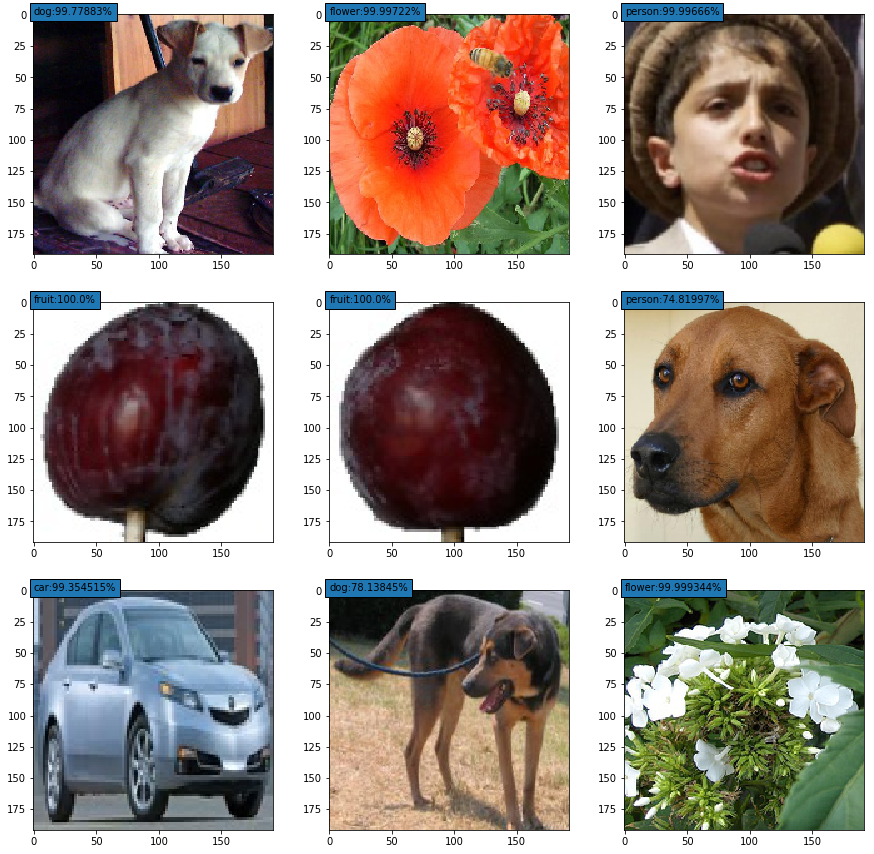

In [56]:
testImageLinks, testImageLabels = getTestLinksAndLabels(actualTestObjs)
prediction_list, prediction_label = predictActualTest(testImageLinks)

In [65]:
print('Number of testImage labels :', len(testImageLabels))
print('Number of predicted labels :', len(prediction_label))
testImage_label_array = np.array(testImageLabels)
prediction_label_array = np.array(prediction_label)
total_match = np.sum(testImage_label_array == prediction_label_array)
prediction_accuracy = (total_match / len(testImage_label_array))*100
print('total_match: ',total_match)
print('prediction accuracy: ',prediction_accuracy,'%')

Number of testImage labels : 1379
Number of predicted labels : 1379
total_match:  1235
prediction accuracy:  89.55765047135606 %
